# Indoor scene recognition

This notebook uses the [indoorCVPR](http://web.mit.edu/torralba/www/indoor.html) dataset to identify among 67 classes of indoor scenes. The figure below lists the 67 diffent classes.

![indoor classes](http://web.mit.edu/torralba/www/allIndoors.jpg)

The data set comes from:
> A. Quattoni, and A.Torralba. Recognizing Indoor Scenes. IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2009.

The best performance from the paper was **74.4% accuracy**. With the basic FastAI defaults, we've achieved **77.0% accuracy**. Additional fine-tuning and training could potentially achieve better results.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision.all import *

## Download the data

In [3]:
indoorCVPR = "http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar"

The built-in `untar_data()` function only supports `.gz` files. To extract tar files with [transparent compression](https://docs.python.org/3/library/tarfile.html), we need to create our own `extract_func`. 

In [4]:
def extract_tar(fname, dest=None):
    "Extract tar with transparent compression"
    dest = Path(fname).parent if dest is None else dest
    fname = str(fname)
    tarfile.open(fname, "r").extractall(dest)

In [45]:
path = untar_data(indoorCVPR, extract_func=extract_tar)

In [6]:
Path.BASE_PATH = path
path.ls()

(#68) [Path('nursery'),Path('livingroom'),Path('computerroom'),Path('operating_room'),Path('closet'),Path('bedroom'),Path('fastfood_restaurant'),Path('gameroom'),Path('tv_studio'),Path('winecellar')...]

Note: ifyou have issues downloading the tar file, try using `wget` and then running `untar_data()` again.

In [7]:
# !wget {indoorCVPR} -O URLs.path(indoorCVPR)

## Load the data

In the original paper, only a subset of the data was used. The full dataset contains 15,620 images. But only 80 images per class (5,360 images) were used for the training set and 20 images per class (1,340 images) for the test set.

To better compare results, we will first use the same subset as the in the paper. The training and test sets are stored in the [TrainingImages.txt](http://web.mit.edu/torralba/www/TrainingImages.txt) and [TestImages.txt](http://web.mit.edu/torralba/www/TestImages.txt) files respectively.

In [8]:
download_url("http://web.mit.edu/torralba/www/TrainImages.txt", "TrainImages.txt")
download_url("http://web.mit.edu/torralba/www/TestImages.txt", "TestImages.txt")

Read each file into a list.

In [9]:
with open("TrainImages.txt", "r") as f:
    train_images = L(f.read().splitlines())

with open("TestImages.txt", "r") as f:
    test_images = L(f.read().splitlines())

train_images, test_images

((#5360) ['gameroom/bt_132294gameroom2.jpg','poolinside/inside_pool_and_hot_tub.jpg','winecellar/bodega_12_11_flickr.jpg','casino/casino_0512.jpg','livingroom/living58.jpg','mall/4984307.jpg','corridor/pasilltmpo_t.jpg','laboratorywet/laboratorio_quimica_07_05_altavista.jpg','bookstore/CIMG2743.jpg','casino/casino_0044.jpg'...],
 (#1340) ['kitchen/int474.jpg','operating_room/operating_room_31_03_altavista.jpg','restaurant_kitchen/restaurant_kitchen_google_0075.jpg','videostore/videoclub_05_14_flickr.jpg','poolinside/piscine_interieureee.jpg','videostore/blockbuster_08_10_flickr.jpg','poolinside/piscina_cubierta_07_19_altavista.jpg','mall/mall26.jpg','kindergarden/toddler.jpg','buffet/Buffet_1.jpg'...])

Map the file names to their paths.

In [10]:
train = train_images.map(lambda f: path / f)
valid = test_images.map(lambda f: path / f)
train, valid

((#5360) [Path('gameroom/bt_132294gameroom2.jpg'),Path('poolinside/inside_pool_and_hot_tub.jpg'),Path('winecellar/bodega_12_11_flickr.jpg'),Path('casino/casino_0512.jpg'),Path('livingroom/living58.jpg'),Path('mall/4984307.jpg'),Path('corridor/pasilltmpo_t.jpg'),Path('laboratorywet/laboratorio_quimica_07_05_altavista.jpg'),Path('bookstore/CIMG2743.jpg'),Path('casino/casino_0044.jpg')...],
 (#1340) [Path('kitchen/int474.jpg'),Path('operating_room/operating_room_31_03_altavista.jpg'),Path('restaurant_kitchen/restaurant_kitchen_google_0075.jpg'),Path('videostore/videoclub_05_14_flickr.jpg'),Path('poolinside/piscine_interieureee.jpg'),Path('videostore/blockbuster_08_10_flickr.jpg'),Path('poolinside/piscina_cubierta_07_19_altavista.jpg'),Path('mall/mall26.jpg'),Path('kindergarden/toddler.jpg'),Path('buffet/Buffet_1.jpg')...])

We'll create our own custom splitter. The entire dataset will be the `train` set plus the`valid` set. Generate the indexes of all the training set, followedbythe indexes of all the validation set.

In [11]:
def IndoorCvprSplitter(train, valid):
    def _inner(o):
        return range(len(train)), range(len(train), len(train) + len(valid))

    return _inner

Now we create our `DataBlock`.

In [12]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=IndoorCvprSplitter(train, valid),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224),
    batch_tfms=aug_transforms(),
)

Create the `DataLoaders` from the `DataBlock`. The `source` of the `DataLoaders` is the combined `train` and `valid` sets.

In [13]:
dls = db.dataloaders(train + valid)
len(dls.train_ds), len(dls.valid_ds), dls.vocab

(5360,
 1340,
 (#67) ['airport_inside','artstudio','auditorium','bakery','bar','bathroom','bedroom','bookstore','bowling','buffet'...])

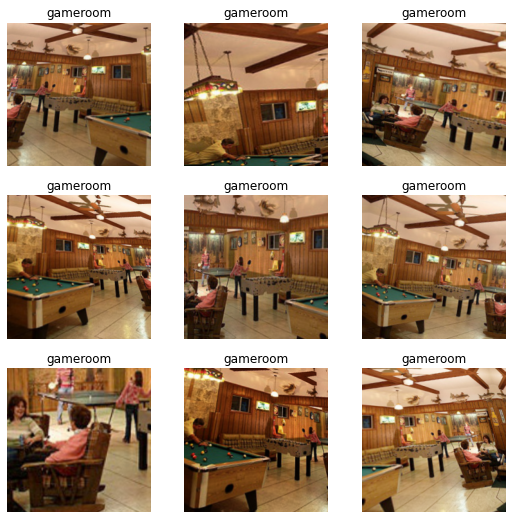

In [14]:
dls.show_batch(unique=True)

## Training: Resnet34

In [15]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.013182567432522774)

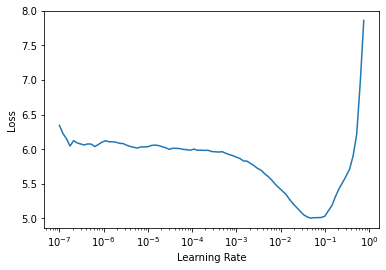

In [16]:
learn.lr_find()

In [17]:
learn.fine_tune(10, base_lr=0.01)

epoch,train_loss,valid_loss,error_rate,time
0,3.327254,1.924333,0.482090,00:15


epoch,train_loss,valid_loss,error_rate,time
0,2.100306,1.289752,0.371642,00:19
1,1.985753,1.803787,0.468657,00:19
2,2.122634,1.887535,0.490299,00:18
3,2.040694,1.812289,0.464179,00:19
4,1.788977,1.655779,0.427612,00:19
5,1.534207,1.399267,0.389552,00:19
6,1.277923,1.219036,0.338806,00:19
7,1.058708,1.068640,0.284328,00:19
8,0.867167,0.999728,0.273134,00:19
9,0.769934,0.981932,0.267910,00:19


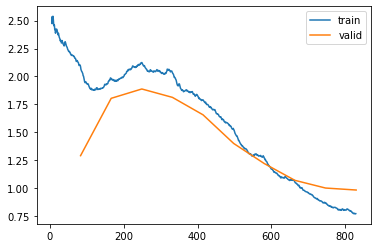

In [18]:
learn.recorder.plot_loss()

With the fastai defaults, we are able to achieve similar accuracy to that of the original paper. The best performance from the paper was **74.4% accuracy**. Here we've achieved around **73.3% accuracy**.

In [61]:
learn.save("stage-1")

Path('models/stage-1.pth')

## Interpretation

In [20]:
learn.load("stage-1")
interp = ClassificationInterpretation.from_learner(learn)

In [21]:
interp.most_confused(min_val=3)

[('grocerystore', 'toystore', 7),
 ('nursery', 'children_room', 6),
 ('bookstore', 'library', 5),
 ('deli', 'bakery', 5),
 ('auditorium', 'concert_hall', 4),
 ('bedroom', 'children_room', 4),
 ('bakery', 'jewelleryshop', 3),
 ('bar', 'dining_room', 3),
 ('bookstore', 'videostore', 3),
 ('children_room', 'kindergarden', 3),
 ('corridor', 'museum', 3),
 ('dentaloffice', 'operating_room', 3),
 ('inside_subway', 'inside_bus', 3),
 ('kindergarden', 'children_room', 3),
 ('library', 'bookstore', 3),
 ('restaurant', 'bar', 3),
 ('shoeshop', 'jewelleryshop', 3),
 ('toystore', 'grocerystore', 3),
 ('trainstation', 'subway', 3)]

These mistakes look reasonable. For example, a restaurant and a bar could look very similar.

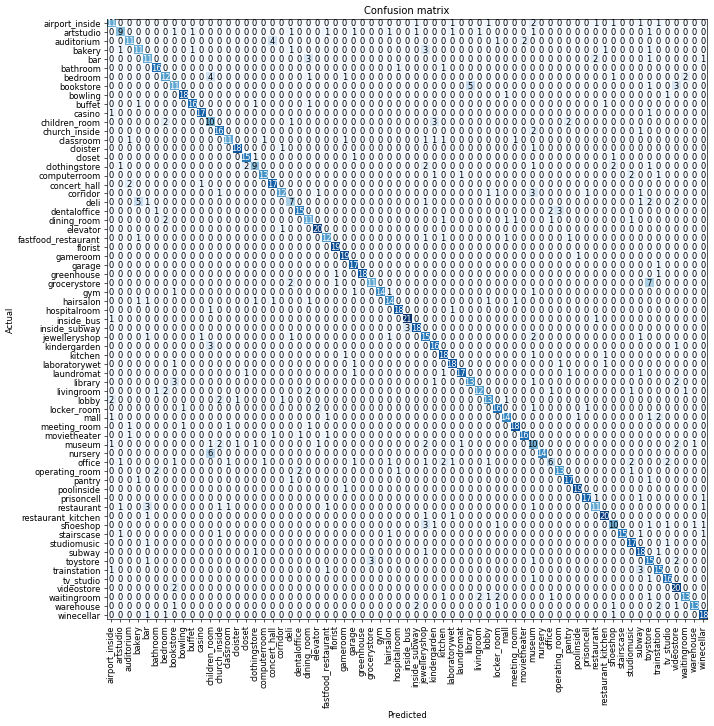

In [22]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

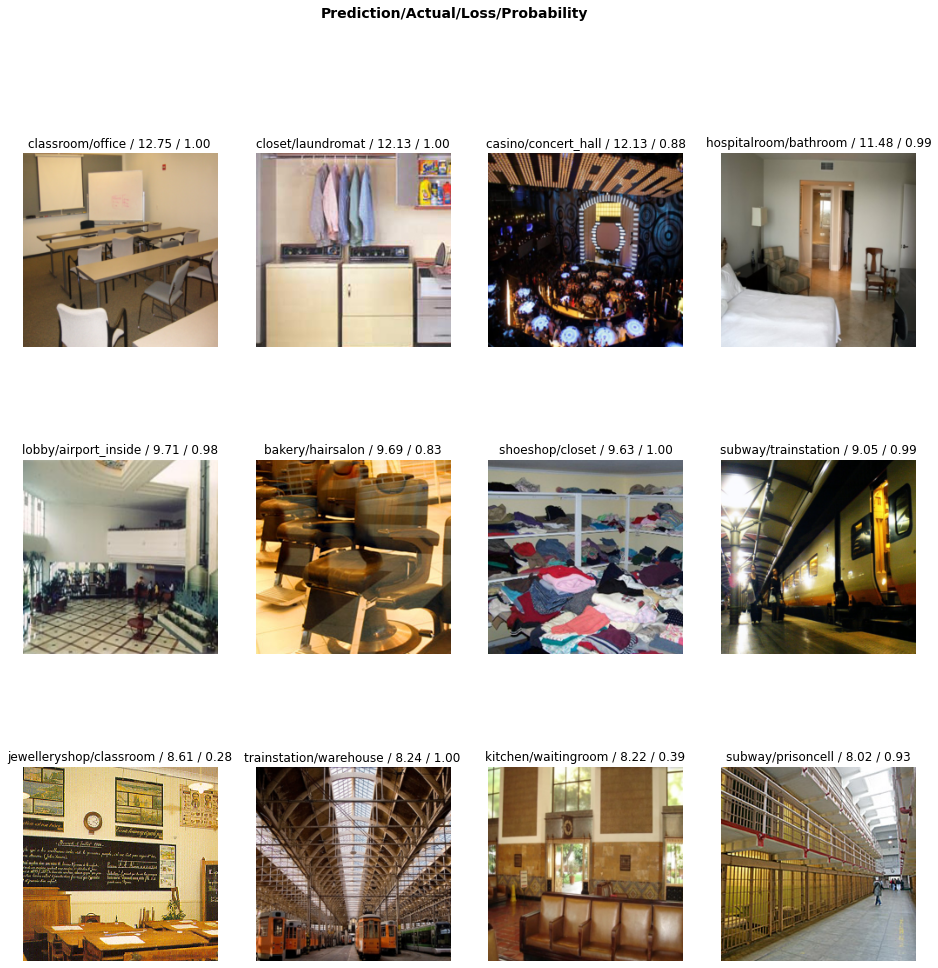

In [23]:
interp.plot_top_losses(12, figsize=(16, 16))

## Load all the data

Now let's try traininga model using all 15K images. We'll also use a larger neural network architecture.

In [24]:
dls_all = ImageDataLoaders.from_folder(
    path=path,
    valid_pct=0.2,
    seed=42,
    item_tfms=RandomResizedCrop(224),
    batch_tfms=aug_transforms(),
)
len(dls_all.train_ds), len(dls_all.valid_ds), dls_all.vocab

(12496,
 3124,
 (#67) ['airport_inside','artstudio','auditorium','bakery','bar','bathroom','bedroom','bookstore','bowling','buffet'...])

In [25]:
learn50 = cnn_learner(dls_all, resnet50, metrics=error_rate)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.004365158267319202)

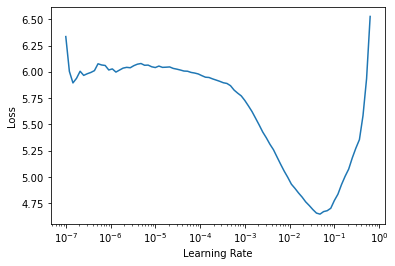

In [26]:
learn50.lr_find()

In [27]:
learn50.fine_tune(10, base_lr=0.003)

epoch,train_loss,valid_loss,error_rate,time
0,2.425984,1.478479,0.405250,00:56


epoch,train_loss,valid_loss,error_rate,time
0,1.605136,1.037028,0.305058,01:13
1,1.506856,1.049733,0.291613,01:12
2,1.455563,1.083757,0.295455,01:12
3,1.308159,1.011194,0.286812,01:13
4,1.152443,0.932409,0.263444,01:12
5,1.044281,0.880593,0.242638,01:12
6,0.875801,0.758903,0.220551,01:12
7,0.715721,0.791394,0.220551,01:12
8,0.597938,0.742289,0.208707,01:12
9,0.572080,0.734872,0.202945,01:12


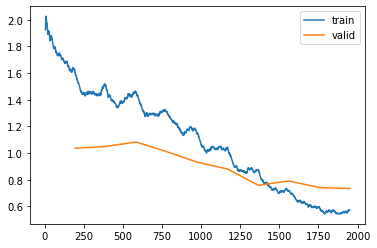

In [28]:
learn50.recorder.plot_loss()

In [49]:
learn50.save("stage-2")

Path('models/stage-2.pth')

In [30]:
interp50 = ClassificationInterpretation.from_learner(learn50)

In [31]:
interp50.most_confused(min_val=7)

[('livingroom', 'bedroom', 13),
 ('bedroom', 'livingroom', 12),
 ('livingroom', 'dining_room', 12),
 ('kitchen', 'dining_room', 10),
 ('library', 'bookstore', 10),
 ('restaurant', 'bar', 9),
 ('bar', 'restaurant', 7),
 ('deli', 'bakery', 7),
 ('inside_bus', 'inside_subway', 7),
 ('kitchen', 'pantry', 7),
 ('movietheater', 'auditorium', 7)]

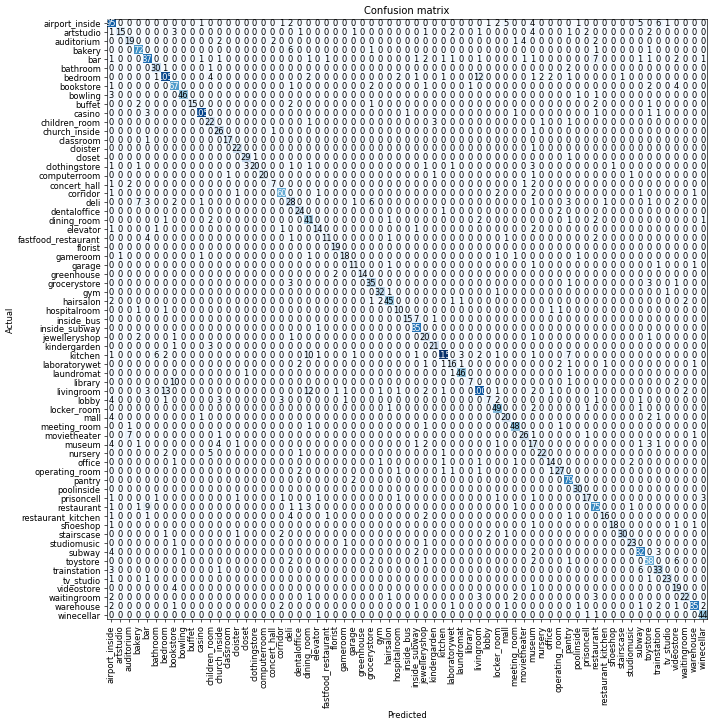

In [32]:
interp50.plot_confusion_matrix(figsize=(12, 12), dpi=60)

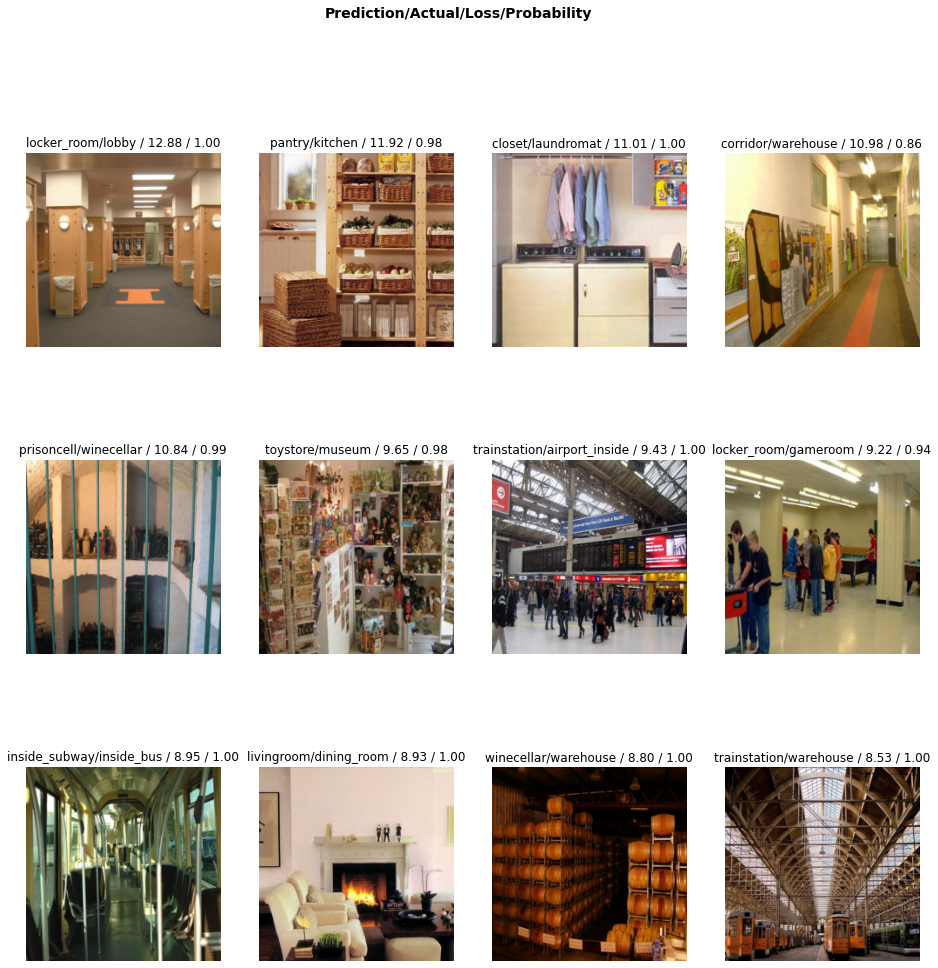

In [33]:
interp50.plot_top_losses(12, figsize=(16, 16))

## Export

In [67]:
learn50.export(Path.cwd() / "export50.pkl")